<a href="https://colab.research.google.com/github/Sagacious007/BIG-data-assessment/blob/main/Projectassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import nltk
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from tqdm import tqdm
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwords = stopwords.words('english')
from transformers import pipeline
# print(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim_models (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim_models


In [1]:
pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=50d00d79a3cd0dfbb2f262d9e0a46a6e0f92241ef6e4ad3d2e582b9a7b48184f
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 3.4 MB/s 
     |████████████████████████████████| 101 kB 7.1 MB/s 
     |████████████████████████████████| 596 kB 48.3 MB/s 
     |████████████████████████████████| 6.6 MB 13.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
# Sentiment model
model_sentiment = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [5]:
# Website forum address
website = 'https://rheumatoidarthritis.net/forums'
# Domain
website_origin = 'https://rheumatoidarthritis.net'

# Crawler

In [6]:
# Get all the links to the stories from the forum
links = []
for i in range(100):
    # Iterate 100 pages of the forum
    website_pagination = website + f'?page={i}'
    req = requests.get(website_pagination)
    parsed_html = BeautifulSoup(req.text)
    # Get the threads and find all the articles in it, article is the post from the story
    for post in parsed_html.find('div', attrs={'class':'forums-index__threads'}).find_all('article'):
        # From the post extract the link to the story and make it usable for our next step
        links.append(website_origin + post.find('a')['href'])
        print(post.find('a')['href'])

/forums/nodules
/forums/ask-me-anything-live
/forums/just-diagnosed-with-seropositive-ra-61-years-old
/forums/help-im-alone-confused-and-in-pain
/forums/pain-in-lower-right-quadrant-of-back
/forums/effects-of-covid-vaccines-on-our-ra
/forums/diagnosed-today-34yr-old
/forums/ra-disappearing
/forums/seronegative-odd-symptoms
/forums/work-issues
/forums/headche-problem-in-ra
/forums/nodules
/forums/ask-me-anything-live
/forums/just-diagnosed-with-seropositive-ra-61-years-old
/forums/help-im-alone-confused-and-in-pain
/forums/pain-in-lower-right-quadrant-of-back
/forums/effects-of-covid-vaccines-on-our-ra
/forums/diagnosed-today-34yr-old
/forums/ra-disappearing
/forums/seronegative-odd-symptoms
/forums/work-issues
/forums/headche-problem-in-ra
/forums/just-diagnosed-2
/forums/energy-humira
/forums/rheum
/forums/diagnosed-later-in-age
/forums/getting-on-humira
/forums/medication-reset
/forums/holistic-doctor
/forums/pain-and-ra
/forums/humira-concerns
/forums/nodules-face-neck-scalp
/forums

In [7]:
print(len(set(links)))

990


In [9]:
# Extract title, content and comments from a story
data = {}
for link in tqdm(links):
    try:
        req = requests.get(link)
        parsed_html = BeautifulSoup(req.text)
        # Get the title - h1 tag
        title = parsed_html.find('div', attrs={'class':'forum-thread__content'}).find('h1').text
        content = ''
        # Get the content from the multiple p tags from the body of the story
        for p in parsed_html.find('div', attrs={'class':'forum-thread__body'}).find_all('p'):
            content += p.text
        comments = []
        # Get the content from the comments same as the main content
        for div in parsed_html.find_all('div', attrs={'class':'thread-reply__body'}):
            content_comment = ''
            for p in div.find_all('p'):
                content_comment += p.text
            comments.append(content_comment)
        meta_data = {'content':content, 'comments':comments, 'title':title}
        data[link] = meta_data
    except Exception as e:
        print(e)

 45%|████▌     | 451/1002 [05:22<05:16,  1.74it/s]

'NoneType' object has no attribute 'find'


100%|██████████| 1002/1002 [11:29<00:00,  1.45it/s]


In [10]:
print(len(data.keys()))

989


In [11]:
# Save the data as json
with open('data.json', 'w') as f:
    json.dump(data, f)

# Preprocess

In [12]:
# Get the most frequent words so we can eliminate really rare words from our corpus
def most_frequent_words(posts:list):
    count_vectorizer =  CountVectorizer(max_features=1000)
    feature_vector = count_vectorizer.fit(posts)
    features = feature_vector.get_feature_names()
    train_ds_features = count_vectorizer.transform(posts)
    features_counts =  np.sum(train_ds_features.toarray(),axis=0)
    features_counts = pd.DataFrame(dict(features = features, counts = features_counts))
    features_counts.sort_values('counts', ascending=False)[0:15]
    return features_counts['features'].values.tolist()

In [13]:
# Text cleaning function - stopwords, numbers, small words, links, and adhoc words
def remove_stopwords_and_numbers(post:str):
    tokens = word_tokenize(post)
    new_post = [word for word in tokens if word not in stopwords and not word.isnumeric() and word not in punctuation and len(word)>3 and word.lower() != 'net' and word.lower() != 'https' and not word.startswith('http') and not word.endswith('.net')]
    return ' '.join(new_post)

In [14]:
# function to remove not freq
def remove_not_frequent(post:str, most_frequent:list):
    tokens = word_tokenize(post)
    new_post = [word for word in tokens if word in most_frequent]
    return ' '.join(new_post)

In [15]:
# Get all texts
all_posts = []
for link, meta in data.items():
    all_posts.append(meta['content'])
    for comment in meta['comments']:
        all_posts.append(comment)

In [16]:
most_frequent = most_frequent_words(all_posts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
# Clean the data with - preprocessing
data_clean = {}
for link, meta in data.items():
    content = meta['content']
    new_content = remove_stopwords_and_numbers(content)
    
    new_comments = []
    for comment in meta['comments']:
        new_comments.append(remove_stopwords_and_numbers(comment))
    data_clean[link] = {'content':new_content, 'comments':new_comments, 'title': remove_stopwords_and_numbers(meta['title'])}

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
# Save into a json object clean data
with open('data_clean.json', 'w') as f:
    json.dump(data_clean, f)

# Topic Modeling

In [24]:
# Open clean data from json file
with open('data_clean.json', 'r') as f:
  data_clean = json.load(f)

In [25]:
# Take all texts, content and comments into one list
all_text = []
for link, meta in data_clean.items():
    all_text.append(meta['content'])
    for comment in meta['comments']:
        all_text.append(comment)

In [26]:
# Make all texts lowercase
all_text_lowercase = []
for text in all_text:
    new_text = word_tokenize(text)
    new_text = [word.lower() for word in new_text if word.lower() != 'net']
    all_text_lowercase.append(' '.join(new_text))

## Word Cloud

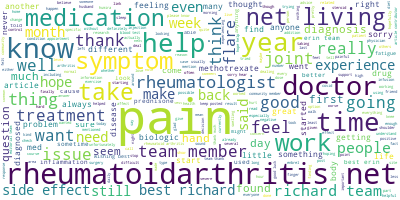

In [27]:
# Join the different processed titles together.
long_string = ','.join(all_text_lowercase)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [28]:
# Sentence to word function
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [29]:
data_words = list(sent_to_words(all_text_lowercase))

In [30]:
print(data_words[:1][0][:30])

['does', 'anyone', 'know', 'nodules', 'show', 'skin']


In [31]:
data_words

[['does', 'anyone', 'know', 'nodules', 'show', 'skin'],
 ['responded',
  'another',
  'thread',
  'thought',
  'would',
  'share',
  'article',
  'well',
  'net',
  'what',
  'is',
  'ra',
  'ra',
  'nodules',
  'experiencing',
  'lumps',
  'near',
  'skin',
  'surface',
  'hope',
  'helps',
  'wishing',
  'best',
  'lori',
  'team',
  'member'],
 ['hello',
  'lori',
  'thought',
  'heard',
  'nodules',
  'show',
  'places',
  'skin',
  'obvious',
  'finger',
  'joint',
  'appox',
  'year',
  'another',
  'early',
  'diagnoses',
  'finger',
  'joint',
  'came',
  'disappeared',
  'reason',
  'asking',
  'places',
  'nodule',
  'growing',
  'lung',
  'followed',
  'possible',
  'cancer',
  'guess',
  'next',
  'rheumatologist',
  'also',
  'look',
  'scans',
  'done',
  'scan',
  'base',
  'skull',
  'hips',
  'what',
  'might',
  'thought',
  'nodules',
  'developing',
  'lungs',
  'heart',
  'thanks',
  'response',
  'john'],
 ['nodules',
  'sometimes',
  'occur',
  'lung',
  'article

In [32]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [33]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0,
  '0.012*"pain" + 0.011*"best" + 0.008*"team" + 0.008*"know" + 0.006*"also" + '
  '0.006*"doctor" + 0.006*"rheumatologist" + 0.005*"thanks" + 0.005*"like" + '
  '0.005*"help"'),
 (1,
  '0.012*"pain" + 0.009*"years" + 0.007*"hope" + 0.006*"doctor" + '
  '0.006*"thank" + 0.005*"know" + 0.005*"like" + 0.005*"good" + 0.005*"team" + '
  '0.005*"help"'),
 (2,
  '0.006*"would" + 0.006*"pain" + 0.005*"issues" + 0.005*"could" + '
  '0.005*"good" + 0.005*"keep" + 0.005*"well" + 0.004*"started" + 0.004*"back" '
  '+ 0.004*"week"'),
 (3,
  '0.026*"pain" + 0.012*"like" + 0.009*"doctor" + 0.006*"best" + '
  '0.006*"thanks" + 0.006*"team" + 0.006*"net" + 0.005*"diagnosed" + '
  '0.005*"feel" + 0.005*"know"'),
 (4,
  '0.010*"like" + 0.009*"pain" + 0.008*"net" + 0.008*"know" + 0.007*"living" + '
  '0.006*"best" + 0.006*"years" + 0.006*"help" + 0.006*"treatment" + '
  '0.006*"also"'),
 (5,
  '0.011*"know" + 0.011*"pain" + 0.007*"net" + 0.007*"best" + 0.007*"feel" + '
  '0.007*"team" + 0.006*"would"

In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = './ldavis_prepared_'+str(num_topics)
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

AttributeError: ignored

In [42]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.024733  0.004835       1        1  22.718890
4     -0.012678 -0.012071       2        1  16.388421
8     -0.043263  0.022588       3        1  14.980859
3     -0.016092 -0.018054       4        1  14.473418
0     -0.013763 -0.000871       5        1   9.104178
9     -0.001742  0.015440       6        1   5.388270
1      0.017454  0.029817       7        1   5.088646
6      0.040949 -0.071741       8        1   4.797813
7     -0.025362 -0.006732       9        1   3.895236
2      0.079230  0.036788      10        1   3.164268, topic_info=          Term         Freq        Total Category  logprob  loglift
280       pain  2235.000000  2235.000000  Default  30.0000  30.0000
148      thank   612.000000   612.000000  Default  29.0000  29.0000
144       good   614.000000   614.000000  Default  28.0000  28.0000
220      years   930.000000   930.000000  Default  27.0000  27.0000
25        well   583.000000   583.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
183       many    18.951834   627.430128  Topic10  -5.7232  -0.0465
421  diagnosed    18.997855   643.920520  Topic10  -5.7208  -0.0700
17         net    20.201434  1188.390909  Topic10  -5.6593  -0.6214
352       help    19.052837   790.987246  Topic10  -5.7179  -0.2728
2         know    18.880764  1417.852121  Topic10  -5.7269  -0.8655

[805 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
11779      1  0.960814   aafter
96         1  0.179366     able
96         2  0.224207     able
96         3  0.104630     able
96         4  0.211751     able
...      ...       ...      ...
220       10  0.026878    years
9778       4  0.164557   yellow
9778      10  0.658228   yellow
11449      1  0.960813     yetc
9687       3  0.620329  zohydro

[2439 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 9, 4, 1, 10, 2, 7, 8, 3])

# Sentiment analysis

In [44]:
sent = []
s_val = []
for s in all_text:
    if len(s) < 2000:
        result = model_sentiment(s)[0]
        if result['label'] == "NEGATIVE":
            sent.append(-1)
            s_val.append(-result['score'])
        else:
            sent.append(1)
            s_val.append(result['score'])
    else:
        sent.append(0)
        s_val.append(0)


In [45]:
df = pd.DataFrame({'text': all_text, 'sentiment_value':s_val, 'sentiment':sent})

In [46]:
df

,text,sentiment_value,sentiment
0,Does anyone know nodules show skin,-0.980372,-1
1,responded another thread thought would share a...,-0.977514,-1
2,Hello Lori thought heard nodules show places s...,-0.987397,-1
3,nodules sometimes occur lung article Mayo clin...,0.741058,1
4,scheduled Scan neck thigh Pulmonologist visit ...,-0.958718,-1
...,...,...,...
4359,Welcome TC3120 First totally normal feel overw...,0.895511,1
4360,Health Gainer purely herbal manufacturing guar...,0.610024,1
4361,work year poly diagnosis seropositive insuranc...,-0.823155,-1
4362,Lavande certain amount fear concern certainly ...,-0.918513,-1


In [47]:
df.to_csv('text_with_sentiment.csv')